<a href="https://colab.research.google.com/github/TejaPravs/Homework2/blob/main/Emotional_tone_prediction_in_movies_using_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Roberta for Emotional tone Prediction in Movies




### Introduction

In this tutorial I will be fine tuning a roberta model for the **Sentiment Analysis** problem.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)

#### Technical Details

This script leverages on multiple tools designed by other teams. Details of the tools used below. Please ensure that these elements are present in your setup to successfully implement this script.

 - Data:
	 - I will be using the dataset available at [Kaggle Competition](https://www.kaggle.com/c/movie-review-sentiment-analysis-kernels-only)
	 - I will be referring only to the first csv file from the data dump: `train.tsv`

 - Language Model Used:
	 - The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018.
	 - [Blog-Post](https://ai.facebook.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/)
	 - [Research Paper](https://arxiv.org/pdf/1907.11692)
     - [Documentation for python](https://huggingface.co/transformers/model_doc/roberta.html)


 - Hardware Requirements:
	 - Python 3.6 and above
	 - Pytorch, Transformers and All the stock Python ML Libraries
	 - GPU enabled setup

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* tqdm
* sklearn
* Robert Model and Tokenizer

Followed by that we will preapre the device for CUDA execeution. This configuration is needed if you want to leverage on onboard GPU.

In [31]:
!pip install transformers
import transformers
print(transformers.__version__)

4.47.1


In [32]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers

import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [33]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [34]:
train = pd.read_csv('/content/generated_emotional_tones.tsv', delimiter='\t')
train = train.rename(columns = {'Emotional_tones': 'emotional_tones'})

In [35]:
train.shape

(15000, 3)

In [36]:
train.head()

,original_title,overview,emotional_tones
0,All Tomorrow's Parties,A kaleidoscopic journey into the parallel musi...,"intriguing, imaginative, euphoric, enchanting"
1,Troy,"In year 1250 B.C. during the late Bronze age, ...","romantic, perilous, tense, fearless"
2,Varieté,The murderer “Boss” Huller – after having spen...,"intriguing, melancholic, raw, investigative"
3,Silenced,Only 11 Americans have ever been charged under...,"provocative, empowering, intellectual, investi..."
4,Alexander Graham Bell: The Sound and the Silence,True story of Alexander Graham Bell's inventio...,"inspiring, nostalgic, profound, innovative"


In [37]:
train.describe()

,original_title,overview,emotional_tones
count,15000,15000,15000
unique,14724,14942,6314
top,Wuthering Heights,No overview found.,"tense, ominous, intriguing, perilous"
freq,5,47,155


In [38]:
import numpy as np

train['overview'] = train['overview'].replace('No overview found.', np.nan)

print(train.isna().sum())

train = train.dropna(subset = ['overview'])

print()

print(train.isna().sum())

print(train.shape)

original_title      0
overview           47
emotional_tones     0
dtype: int64

original_title     0
overview           0
emotional_tones    0
dtype: int64
(14953, 3)


In [39]:
# Assuming the emotional_tones column contains error messages for invalid labels
invalid_phrases = [
    "I'm sorry",
    "It looks like",
    "It seems",
    "Please provide",
    "Sure!"
]

# Keeping only the valid rows
train = train[~train['emotional_tones'].str.contains('|'.join(invalid_phrases), na=False)]

# Check the shape of the cleaned dataset
print(train.shape)

# Preview the cleaned dataset
print(train.head())

(14943, 3)
                                     original_title  \
0                            All Tomorrow's Parties   
1                                              Troy   
2                                           Varieté   
3                                          Silenced   
4  Alexander Graham Bell: The Sound and the Silence   

                                            overview  \
0  A kaleidoscopic journey into the parallel musi...   
1  In year 1250 B.C. during the late Bronze age, ...   
2  The murderer “Boss” Huller – after having spen...   
3  Only 11 Americans have ever been charged under...   
4  True story of Alexander Graham Bell's inventio...   

                                     emotional_tones  
0      intriguing, imaginative, euphoric, enchanting  
1                romantic, perilous, tense, fearless  
2        intriguing, melancholic, raw, investigative  
3  provocative, empowering, intellectual, investi...  
4         inspiring, nostalgic, profound, inno

In [40]:
valid_tones = ['humorous', 'inspiring', 'heartwarming', 'bittersweet', 'euphoric', 'melancholic', 'tense', 'romantic',
               'nostalgic', 'intriguing', 'comforting', 'provocative', 'empowering', 'profound', 'enchanting', 'alarming', 'perilous', 'ominous',
               'fearless', 'imaginative', 'methodical', 'investigative', 'intellectual', 'sophisticated', 'innovative', 'futuristic', 'wholesome', 'raw', 'optimistic']

# defining function to clean and filter tones
def filter_tones(tones):
    return ", ".join(tone.strip() for tone in tones.split(", ") if tone.strip() in valid_tones)

# Clean and filter the 'emotional_tones' column
train['emotional_tones'] = train['emotional_tones'].apply(filter_tones)

# Extract and sort unique tones
unique_cleaned_tones = sorted(
    set(tone for tones in train['emotional_tones'].str.split(", ") for tone in tones if tone.strip())
)

# Display the sorted cleaned tones
print(unique_cleaned_tones)


['alarming', 'bittersweet', 'comforting', 'empowering', 'enchanting', 'euphoric', 'fearless', 'futuristic', 'heartwarming', 'humorous', 'imaginative', 'innovative', 'inspiring', 'intellectual', 'intriguing', 'investigative', 'melancholic', 'methodical', 'nostalgic', 'ominous', 'optimistic', 'perilous', 'profound', 'provocative', 'raw', 'romantic', 'sophisticated', 'tense', 'wholesome']


In [41]:
# Remove malformed or misspelled tones
def clean_tones(tones):
    valid = [tone for tone in tones.split(", ") if tone.strip() in valid_tones]
    return ", ".join(valid)

# Apply cleaning
train['emotional_tones'] = train['emotional_tones'].apply(clean_tones)


In [42]:
train['emotional_tones'] = train['emotional_tones'].str.strip()  # Remove leading/trailing spaces
train = train[train['emotional_tones'] != '']

In [43]:
tones = ['alarming', 'bittersweet', 'comforting', 'empowering', 'enchanting', 'euphoric', 'fearless', 'futuristic', 'heartwarming', 'humorous', 'imaginative', 'innovative', 'inspiring', 'intellectual', 'intriguing', 'investigative', 'melancholic', 'methodical', 'nostalgic', 'ominous', 'optimistic', 'perilous', 'profound', 'provocative', 'raw', 'romantic', 'sophisticated', 'tense', 'wholesome']

tone_to_num = {}
for idx, tone in enumerate(tones):
    tone_to_num[tone] = idx
print(tone_to_num)

{'alarming': 0, 'bittersweet': 1, 'comforting': 2, 'empowering': 3, 'enchanting': 4, 'euphoric': 5, 'fearless': 6, 'futuristic': 7, 'heartwarming': 8, 'humorous': 9, 'imaginative': 10, 'innovative': 11, 'inspiring': 12, 'intellectual': 13, 'intriguing': 14, 'investigative': 15, 'melancholic': 16, 'methodical': 17, 'nostalgic': 18, 'ominous': 19, 'optimistic': 20, 'perilous': 21, 'profound': 22, 'provocative': 23, 'raw': 24, 'romantic': 25, 'sophisticated': 26, 'tense': 27, 'wholesome': 28}


In [44]:
# Assuming you have a tokenizer object already defined
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
def token_count(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=True, truncation = True))

# Adding a new column with the token count
train['token_count'] = train['overview'].apply(lambda x: token_count(x, tokenizer))

# Filter rows that has smaller descriptions less than 50 words
train = train[train['token_count'] >= 50]

# Dropping the temporary 'token_count' column if needed
train = train.drop(columns=['token_count'])

# Check the shape of the filtered dataset
print(train.shape)


(9192, 3)


In [45]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 256
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
# EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

<a id='section03'></a>
### Preparing the Dataset and Dataloader

I will start with defining few key variables that will be used later during the training/fine tuning stage.
Followed by creation of Dataset class - This defines how the text is pre-processed before sending it to the neural network. I will also define the Dataloader that will feed  the data in batches to the neural network for suitable training and processing.
Dataset and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *SentimentData* Dataset Class
- This class is defined to accept the Dataframe as input and generate tokenized output that is used by the Roberta model for training.
- I am using the Roberta tokenizer to tokenize the data in the `TITLE` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`
- To read further into the tokenizer, [refer to this document](https://huggingface.co/transformers/model_doc/roberta.html#robertatokenizer)
- `target` is the encoded category on the news headline.
- The *SentimentData* class is used to create 2 datasets, for training and for validation.
- *Training Dataset* is used to fine tune the model: **80% of the original data**
- *Validation Dataset* is used to evaluate the performance of the model. The model has not seen this data during training.

#### Dataloader
- Dataloader is used to for creating training and validation dataloader that load data to the neural network in a defined manner. This is needed because all the data from the dataset cannot be loaded to the memory at once, hence the amount of dataloaded to the memory and then passed to the neural network needs to be controlled.
- This control is achieved using the parameters such as `batch_size` and `max_len`.
- Training and Validation dataloaders are used in the training and validation part of the flow respectively

In [46]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, tone_to_num):
        self.tokenizer = tokenizer
        self.tone_to_num = tone_to_num
        self.data = dataframe
        self.text = dataframe.overview
        self.targets = dataframe.emotional_tones
        self.max_len = 256

    def __len__(self):
        return len(self.text)


    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        # Tokenize the input text
        inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding = 'max_length',
        truncation = True,
        return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        # Create multi-label targets
        tone_labels = [self.tone_to_num.get(tone_str, None) for tone_str in self.targets[index].split(", ")]
        tone_labels = [tl for tl in tone_labels if tl is not None]  # Filter out invalid tones

        # Initialize labels with the correct size
        bce_labels = [0] * len(self.tone_to_num)  # Length is now 29
        for tl in tone_labels:
            bce_labels[tl] = 1

        return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        'targets': torch.tensor(bce_labels, dtype=torch.long)
        }


In [47]:
train_size = 0.8
train_data=train.sample(frac=train_size,random_state=200)
test_data=train.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(train.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = SentimentData(train_data, tokenizer, MAX_LEN, tone_to_num)
testing_set = SentimentData(test_data, tokenizer, MAX_LEN, tone_to_num)

FULL Dataset: (9192, 3)
TRAIN Dataset: (7354, 3)
TEST Dataset: (1838, 3)


In [48]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `RobertaClass`.
 - This network will have the Roberta Language model followed by a `dropout` and finally a `Linear` layer to obtain the final outputs.
 - The data will be fed to the Roberta Language model as defined in the dataset.
 - Final layer outputs is what will be compared to the `Sentiment category` to determine the accuracy of models prediction.
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.

#### Loss Function and Optimizer
 - `Loss Function` and `Optimizer` and defined in the next cell.
 - The `Loss Function` is used the calculate the difference in the output created by the model and the actual output.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [49]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 29)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [50]:
model = RobertaClass()
model.to(device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

<a id='section05'></a>
### Fine Tuning the Model

After all the effort of loading and preparing the data and datasets, creating the model and defining its loss and optimizer. This is probably the easier steps in the process.

Here we define a training function that trains the model on the training dataset created above, specified number of times (EPOCH), An epoch defines how many times the complete data will be passed through the network.

Following events happen in this function to fine tune the neural network:
- The dataloader passes data to the model based on the batch size.
- Subsequent output from the model and the actual category are compared to calculate the loss.
- Loss value is used to optimize the weights of the neurons in the network.
- After every 5000 steps the loss value is printed in the console.

As you can see just in 1 epoch by the final step the model was working with a loss of 0.8141926634122427.

In [51]:
# Creating the loss function and optimizer
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [52]:
from sklearn.metrics import precision_score, recall_score, f1_score, multilabel_confusion_matrix

def valid(model, testing_loader):
    model.eval()
    tr_loss = 0
    epoch_acc = 0
    nb_tr_steps = 0

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for step, data in enumerate(testing_loader, 1):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float32)

            logits = model(ids, mask, token_type_ids)
            loss = loss_function(logits, targets)
            tr_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.35).float()
            batch_acc = (preds == targets).sum().item() / targets.numel()
            epoch_acc += batch_acc
            nb_tr_steps += 1

            # Collect predictions and targets for metrics
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Compute metrics
    valid_loss = tr_loss / nb_tr_steps
    valid_acc = epoch_acc / nb_tr_steps

    # Multi-label metrics
    precision = precision_score(all_targets, all_preds, average='samples', zero_division=1)
    recall = recall_score(all_targets, all_preds, average='samples', zero_division=1)
    f1 = f1_score(all_targets, all_preds, average='samples', zero_division=1)
    cm = multilabel_confusion_matrix(all_targets, all_preds)

    # Print results
    print(f"Validation Loss: {valid_loss:.4f}")
    print(f"Validation Accuracy: {valid_acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix (per label):")
    print(cm)

    return valid_acc, valid_loss



In [53]:
# Initialize lists to store metrics for plotting
train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
steps = []

for epoch in range(3):
    print(f"Epoch {epoch + 1}/3")
    tr_loss = 0
    epoch_acc = 0
    nb_tr_steps = 0

    model.train()
    for step, data in enumerate(training_loader, 1):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float32)

        logits = model(ids, mask, token_type_ids)
        loss = loss_function(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training metrics
        tr_loss += loss.item()
        probs = torch.sigmoid(logits.detach().cpu())
        preds = (probs >= 0.35).float()
        batch_acc = (preds == targets.detach().cpu()).sum().item() / targets.numel()
        epoch_acc += batch_acc
        nb_tr_steps += 1

        # Log training metrics every 100 steps
        if step % 100 == 0:
            train_loss = tr_loss / nb_tr_steps
            train_acc = epoch_acc / nb_tr_steps
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            steps.append((epoch * len(training_loader)) + step)  # Track step count
            print(f"Step {step}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

            # Evaluate on validation set
            valid_acc, valid_loss = valid(model, testing_loader)
            val_accuracies.append(valid_acc)
            val_losses.append(valid_loss)
            print(f"Validation Loss at Step {step}: {valid_loss:.4f}")
            print(f"Validation Accuracy at Step {step}: {valid_acc:.4f}")

    # Epoch metrics
    epoch_train_loss = tr_loss / nb_tr_steps
    epoch_train_acc = epoch_acc / nb_tr_steps
    print(f"Training Loss Epoch: {epoch_train_loss:.4f}")
    print(f"Training Accuracy Epoch: {epoch_train_acc:.4f}")

print("Training complete.")



Epoch 1/3
Step 100: Training Loss: 0.5023, Training Accuracy: 0.5566
Validation Loss: 0.3759
Validation Accuracy: 0.8310
Precision: 0.4044
Recall: 0.5196
F1 Score: 0.4538
Confusion Matrix (per label):
[[[1778    0]
  [  60    0]]

 [[   0  960]
  [   0  878]]

 [[1790    0]
  [  48    0]]

 [[1464    0]
  [ 374    0]]

 [[1794    0]
  [  44    0]]

 [[1802    0]
  [  36    0]]

 [[1733    0]
  [ 105    0]]

 [[1834    0]
  [   4    0]]

 [[1695    0]
  [ 143    0]]

 [[1326   70]
  [ 376   66]]

 [[1783    0]
  [  55    0]]

 [[1756    0]
  [  82    0]]

 [[1434    0]
  [ 404    0]]

 [[1756    0]
  [  82    0]]

 [[   0  884]
  [   0  954]]

 [[1721    0]
  [ 117    0]]

 [[   0 1288]
  [   0  550]]

 [[1815    0]
  [  23    0]]

 [[1650    0]
  [ 188    0]]

 [[1622    0]
  [ 216    0]]

 [[1827    0]
  [  11    0]]

 [[1498    0]
  [ 340    0]]

 [[1654    0]
  [ 184    0]]

 [[1614    0]
  [ 224    0]]

 [[1552    0]
  [ 286    0]]

 [[   0 1188]
  [   0  650]]

 [[1805    0]
  [  

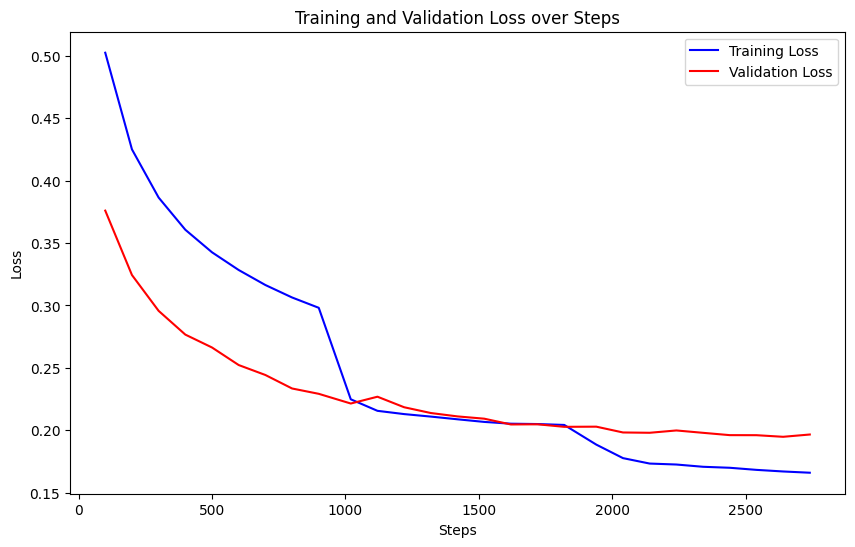

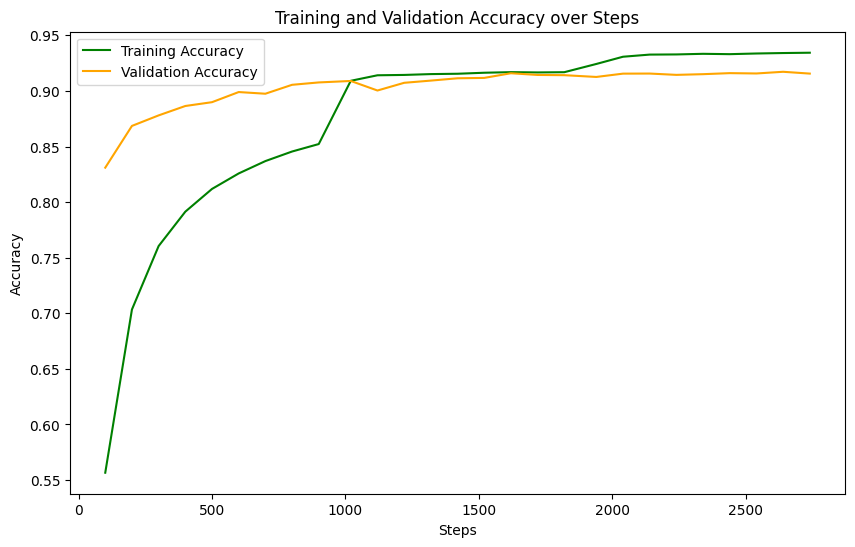

In [54]:
import matplotlib.pyplot as plt

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Training Loss', color='blue')
plt.plot(steps, val_losses, label='Validation Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps')
plt.legend()
plt.savefig('loss_over_steps.png')  # Save for GitHub
plt.show()

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 6))
plt.plot(steps, train_accuracies, label='Training Accuracy', color='green')
plt.plot(steps, val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Steps')
plt.legend()
plt.savefig('accuracy_over_steps.png')  # Save for GitHub
plt.show()


In [ ]:
outputs

tensor([[-5.4717e-02, -1.3106e-02, -7.4805e-02, -1.7144e-01, -2.3141e-03,
          6.0220e-02, -1.0050e-01, -2.2928e-02,  6.7549e-02,  1.4701e-01,
          1.6569e-02,  1.5849e-01, -2.1958e-01,  1.0397e-01,  2.6452e-01,
          1.6763e-01],
        [-7.9450e-02, -4.0141e-02, -1.8531e-01, -1.2258e-01,  6.1988e-02,
          9.9231e-03, -6.2996e-02,  4.9996e-02, -9.4893e-02,  1.8278e-01,
         -7.9654e-02,  9.4997e-02, -1.0181e-01,  1.5750e-01,  3.0294e-01,
          9.1920e-02],
        [-7.3177e-02, -5.0926e-02, -2.7425e-02, -8.7990e-02,  3.1822e-02,
          6.0473e-02, -5.0405e-02,  4.2614e-02,  4.1726e-02,  2.8491e-01,
          1.4312e-01,  1.1740e-01, -1.2281e-01,  1.3756e-01,  2.0290e-01,
          1.0004e-01],
        [-1.4649e-01, -6.0954e-02, -7.1961e-02, -2.6874e-02,  8.6942e-02,
          8.6437e-02, -3.0898e-02,  3.7832e-02,  9.3776e-02,  2.4331e-01,
         -2.9698e-02,  8.9155e-02, -2.2387e-01,  1.6813e-01,  1.7661e-01,
          1.9179e-01],
        [-1.6000e-02

In [ ]:
targets

tensor([[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data.

This unseen data is the 20% of `train.tsv` which was seperated during the Dataset creation stage.
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model.

As you can see the model is predicting the correct category of a given sample to a 69.47% accuracy which can further be improved by training more.

In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

<a id='section07'></a>
### Saving the Trained Model Artifacts for inference

This is the final step in the process of fine tuning the model.

The model and its vocabulary are saved locally. These files are then used in the future to make inference on new inputs of news headlines.

In [ ]:
output_model_file = 'pytorch_roberta_sentiment.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')